Check coefficients for integration schemes - they should all line up nicely for values in the middle and vary smoothly

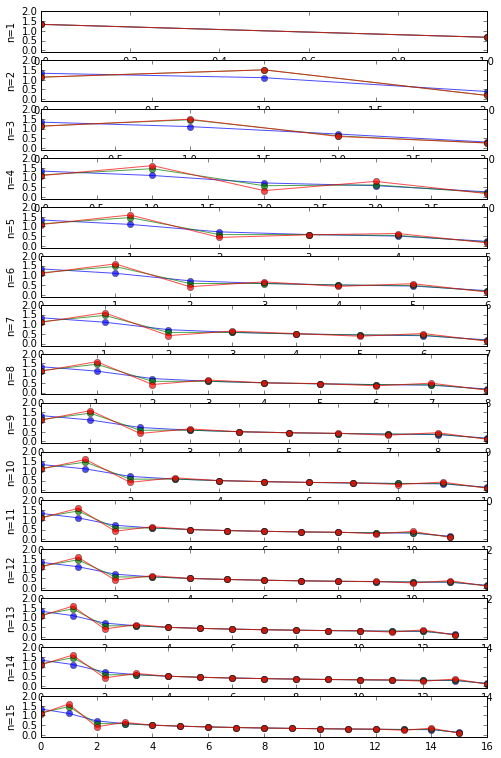

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from maxr.integrator import history

n = 0
f, axes = plt.subplots(15, 1)
for ax in axes:
    n += 1
    for order in (1, 2, 3):
        try:
            ax.plot(history.coefficients(n, order=order), marker='o', alpha=0.7)
        except ValueError:
            continue
    ax.set_ylim(-0.1, 2)
    ax.set_ylabel('n={0}'.format(n))
f.set_size_inches(8, 13)

Define some timesteps to integrate over

In [2]:
tmin, tmax = 0, 30
ts = numpy.linspace(tmin, tmax, 1000)

Check we can integrate things!

In [43]:
expected = -1.2492166377597749

In [45]:
history.integrator(numpy.sin(ts), ts) - expected < 1e-5

True

Turn this into a history integrator for a python function

In [7]:
def evaluate_history_integral(f, ts, order=1):
    """ Evaluate the history integral for a given driving function f
    """
    return numpy.array([0] + [
        history.integrator(f(ts[:idx+1]), ts[:idx+1], order=order)
        for idx in range(1, len(ts))])

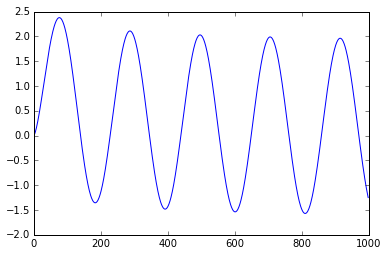

In [8]:
results = evaluate_history_integral(numpy.sin, ts)
plt.plot(results)

Check accuracy of convergence. We use a sinusoidal forcing and plot the response
$$ 
\int_0^{t} \frac{\sin{(\tau)}}{\sqrt{t - \tau}}d\tau = \sqrt{2 \pi}\left[C{\left(\sqrt{\frac{2t}{\pi}}\right)}\sin{t} - S{\left(\sqrt{\frac{2t}{\pi}}\right)}\cos{t}\right]
$$
where $C$ is the Fresnel C (cos) integral, and $S$ is the Fresnel $S$ (sin) integral. Note the solution in the paper is **WRONG**

In [46]:
from scipy.special import fresnel

def solution(t):
    ssc, csc = fresnel(numpy.sqrt(2 * t / numpy.pi)) 
    return numpy.sqrt(2 * numpy.pi) * (
        csc * numpy.sin(t) - ssc * numpy.cos(t))

Show the solution

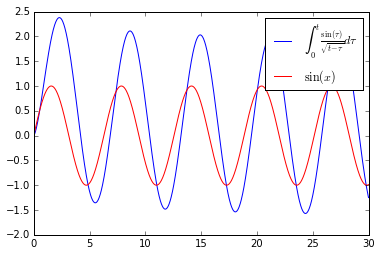

In [47]:
plt.plot(ts, solution(ts), 'b', label=r'$\int_0^{t}\frac{\sin(\tau)}{\sqrt{t-\tau}}d\tau$')
plt.plot(ts, numpy.sin(ts), 'r', label=r'$\sin(x)$')
plt.legend()

and try integration numerically

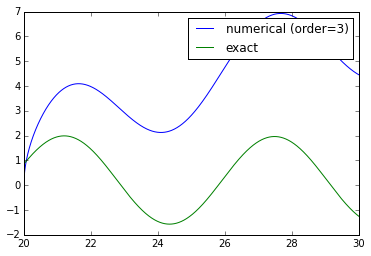

In [50]:
nsteps = 1280
order = 3
tmin = 20
ts = numpy.linspace(tmin, tmax, nsteps)
numeric = evaluate_history_integral(numpy.sin, ts, order=order)
exact = solution(ts)
plt.plot(ts, numeric, 
         label='numerical (order={0})'.format(order))
plt.plot(ts, exact, label='exact')
plt.legend()

In [41]:
numpy.median(numeric - exact) < 1e-6

True

Now we loop through by order and computer the error

In [22]:
from collections import defaultdict

# Set up steps
nstepstep = 25
nsteps = numpy.arange(nstepstep, 500, nstepstep)
spacing = 10 / (nsteps - 1)

# Calculate error
error = defaultdict(list)
for order in (1, 2, 3):
    for N in nsteps:
        ts = numpy.linspace(0, tmax, N)
        err = evaluate_history_integral(numpy.sin, ts, order=order) - solution(ts)
        error[order].append(abs(err).max())

# Convert to arrays
for key, value in error.items():
    error[key] = numpy.asarray(value)

We can plot how the error changes with spacing

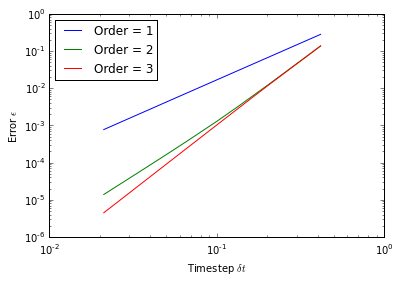

In [23]:
ax = plt.gca()
for order in (1, 2, 3):
    ax.plot(spacing, error[order], label='Order = {0}'.format(order))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Timestep $\delta t$')
ax.set_ylabel(r'Error $\epsilon$')
ax.legend(loc='best')

check that we get reasonable scaling (should be about $\epsilon\sim\delta t ^{\text{order} + 1}$)

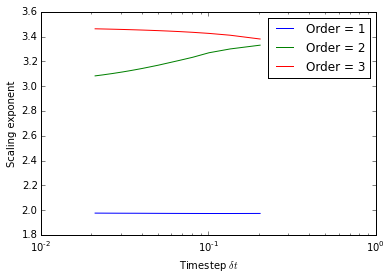

In [24]:
def slope(rise, run):
    return (rise[1:] - rise[0]) / (run[1:] - run[0])

ax = plt.gca()
for order in (1, 2, 3):
    ax.plot(spacing[1:], 
            slope(numpy.log(error[order]), numpy.log(spacing)), 
            label='Order = {0}'.format(order))
ax.set_xscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'Timestep $\delta t$')
ax.set_ylabel('Scaling exponent')